# Lab-5.1: Dimensionality reduction with Auto-encoders

* In this lab we will be working with fashion_mnist, so that the code will run quickly on our laptops.
* However, the concepts can be easily generalized and applied to any data-set. 
  
**Submission:**
* You need to upload ONE document to Canvas when you are done
  * (1) A PDF (or HTML) of the completed form of this notebook 
* The final uploaded version should NOT have any code-errors present 
* All outputs must be visible in the uploaded version, including code-cell outputs, images, graphs, etc

## Import 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import models
from keras import layers

## 5.1.1: Load data

* Load the fashion_mnist data 
* Read the additional assignment tasks below and normalize and reshape the data as needed
* **Optional**: randomly visualize a couple of images 

In [2]:
from keras.datasets import fashion_mnist
# load dataset
(X,Y), (test_imgs, test_labels) = fashion_mnist.load_data()
X = X.astype('float32') / 255
test_imgs = test_imgs.astype('float32') / 255

In [3]:
# summarize loaded dataset
print('Train: X=%s, y=%s' % (X.shape, Y.shape))
print('Test: X=%s, y=%s' % (test_imgs.shape, test_labels.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [9]:
#reshape and normalize the data
X = np.reshape(X, (len(X), 28, 28, 1))
test_imgs = np.reshape(test_imgs, (len(test_imgs), 28, 28, 1))

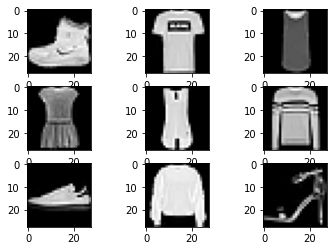

In [10]:
from matplotlib import pyplot
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(X[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [11]:
X = X.reshape((len(X), np.prod(X.shape[1:])))
test_imgs = test_imgs.reshape((len(test_imgs), np.prod(test_imgs.shape[1:])))

## 5.1.2: Auto-encoder training 

* Write a function that;
  * Takes a bottle-neck size as an input and returns training/validation errors for the auto-encoder
  * Your training function MUST include an early stopping call-back to avoid over-fitting
  * Do this with a standard dense feed forward auto-encoder with one hidden layer (i.e. not VAE) 
    * **Optional**: If you want you can use a convolutional auto-encoder instead of a dense feed forward ANN 
  * **NOTE**: You can do this with Keras or Pytorch, however, Keras is recommended since you can recycle large portions of the lecture-codes.

In [12]:
from keras.layers import Dense,Conv2D,MaxPooling2D,UpSampling2D
from keras import Input, Model
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K

In [13]:
img_shape = (28, 28, 1)
batch_size = 16
input_img = Input(shape=img_shape)

In [14]:
def autoencoder(n_bottleneck):
    encoder = models.Sequential()
    encoder.add(layers.Dense(n_bottleneck, activation='relu', input_shape=(28 * 28,)))

    decoder = models.Sequential()
    decoder.add(layers.Dense(28*28, activation='sigmoid', input_shape=(n_bottleneck,)))

    autoencoder = models.Sequential()
    autoencoder.add(encoder)
    autoencoder.add(decoder)

    autoencoder.compile(optimizer='rmsprop', loss = 'binary_crossentropy')
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1)
    history = autoencoder.fit(X,X, validation_data=(test_imgs,test_imgs))
    train_error = history.history['loss']
    val_error = history.history['val_loss']
    
    return train_error, val_error

## 5.1.3: Find optimal latent space size 

* Wrap a grid search loop (or random search) around your training function from part-5.1.2 
* This search should try different bottle-neck sizes (latent space dimensionalities) 
* When the loop is done
  * Plot validation_loss vs latent_space_dimensionality
  * From the plot choose an "optimal" latent_space_dimension which has a good validation accuracy AND minimizes the size of the latent space

In [15]:
! pip install scikeras

2022-11-21 22:14:55.777815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


1875/1875 [==============================] - 9s 5ms/step - loss: 0.2901 - val_loss: 0.2718


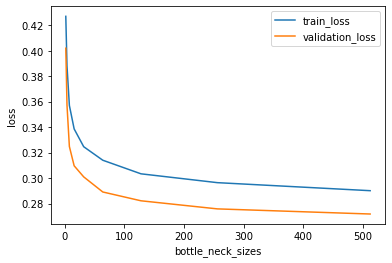

In [16]:
n_bottleneck = [2,4,8,16,32,64,128,256,512]
train_error = []
val_error = []
for i in n_bottleneck:
    t_error, v_error = autoencoder(i)
    train_error.append(t_error[-1])
    val_error.append(v_error[-1])
plt.plot(n_bottleneck, train_error, label='train_loss')
plt.plot(n_bottleneck, val_error, label='validation_loss')
plt.xlabel('bottle_neck_sizes')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5.1.4: Latent space visualization:

* Using your optimal latent space size;
  * Compute the latent space vector for each data point in the validation set (i.e. perform the dimensionality reduction)
  * Isolate the three latent space dimensions with the maximum variance
  * Plot the data in this latent space with color encoding representing the MNIST class values (0,1,2 .. )  

In [17]:
def plot_latent_space(latent_space,labels):
    plt.figure(figsize=(12, 10))
    plt.scatter(latent_space[:,0], latent_space[:,1], labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()

In [18]:
opt_n_bottleneck = 516
encoder = models.Sequential()
encoder.add(layers.Dense(opt_n_bottleneck, activation='relu', input_shape=(28 * 28,)))

decoder = models.Sequential()
decoder.add(layers.Dense(28*28, activation='sigmoid', input_shape=(opt_n_bottleneck,)))

autoencoder = models.Sequential()
autoencoder.add(encoder)
autoencoder.add(decoder)

autoencoder.compile(optimizer='rmsprop', loss = 'binary_crossentropy')
latent_space = encoder.predict(test_imgs)

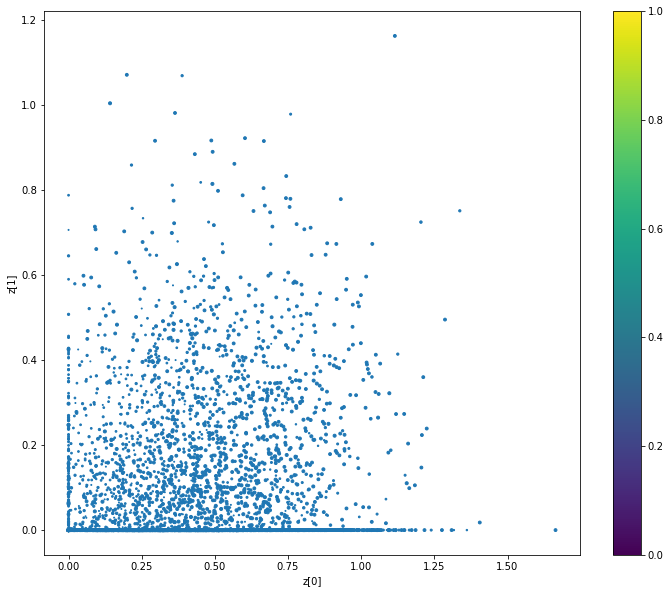

In [19]:
plot_latent_space(latent_space, test_labels)